# HW9: Algorithmic Fairness (due 14 December 2023)

### Note: to complete most of this homework notions from week 11 slides are needed

In this homework you will assess racial bias in the COMPAS algorithm and judges decisions. 

The data is a collection of 7000 criminal cases in Florida in which COMPAS was used and it contains information about defendants' demographics, criminal history (e.g., juvenile criminal records), court decision and recidivism.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

## Data Preparation

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [4]:
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.daDs
df['two_Dear_recid2'] = (df['daDs_from_recid']<=730).astDpe(int)

#generate felonD charge dummies
df['felonD'] = (df['c_charge_degree'] == 'F').astDpe(int)

#generate age dummies
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45', 'Greater than 45':'age_cat_Greater than 45', 'Less than 25':'age_cat_Less than 25'})

#generate ethnicity, race and compas score dummies
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
df['male'] = (df['sex'] == 'Male').astype(int)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high', 'Medium':'score_text_medium', 'Low':'score_text_low'})

AttributeError: 'TimedeltaProperties' object has no attribute 'daDs'

### Setting outcomes and predictors

The *ideal* target variable for the COMPAS algorithm is the presence of a recidivism episode, while for judges is the decision to send the defendant to jail. For the predictors we use some deomgraphic characteristics **excluding race**, criminal hisotry and type of crime. 

In [ ]:
# judge decision: "jailed" = more than one day in jail.
df['jail_days'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['jailed'] = (df.jail_days.dt.days > 1).astype(int)
D = df['jailed']
D.value_counts()

jailed
0    4283
1    2931
Name: count, dtype: int64

In [ ]:
# Algorithm outcome
Y = df['two_year_recid2'] 
Y.value_counts()

two_year_recid2
0    4557
1    2657
Name: count, dtype: int64

In [ ]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


In [ ]:
df['race'].value_counts()

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

In [ ]:
# indicator variable for non-white
NW = (df['race'] != 'Caucasian').astype(int)
NW.describe()

count    7214.000000
mean        0.659828
std         0.473800
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: race, dtype: float64

## Assessing Algorithm: Predict Recidivism from Features

In the following you will predict recidivism from defendants' features using a nested training/test split so we can get clean test-set predictions for the whole dataset (see the notebook and homework on double machine learning for how to do this - week 6).

In [ ]:
import pandas as pd

# perform nested train/test split 
from sklearn.model_selection import train_test_split
X_a, X_b, Y_a, Y_b, D_a, D_b,NW_a, NW_b = train_test_split(X, Y, D, NW, test_size = 0.5)

df_pred = pd.concat([X_a, X_b], axis=0)
NW_New = pd.concat([NW_a, NW_b], axis=0)

#TODO train a logit model to predict recidism (Y) from predictors (X).
#TODO form clean test-set predictions for recidivism in the full dataset
from sklearn.linear_model import LogisticRegression

logit_model_a = LogisticRegression()
#train on first split
logit_model_a.fit(X_a, Y_a)
#predict on second split
Y_pred_b = logit_model_a.predict(X_b)

#train on second split
logit_model_b = LogisticRegression()
logit_model_b.fit(X_b, Y_b)
#predict on first split
Y_pred_a = logit_model_b.predict(X_a)

# Create DataFrame for the first split predictions
df_predictions_a = pd.DataFrame({
    'Y': Y_a,
    'Y_pred': Y_pred_a
})

# Create DataFrame for the second split predictions
df_predictions_b = pd.DataFrame({
    'Y': Y_b,
    'Y_pred': Y_pred_b
})

df_predictions = pd.concat([df_predictions_a, df_predictions_b], axis=0)

Y_new = df_predictions['Y']
Y_pred = df_predictions['Y_pred']


Evaluate test set performance.

Confusion Matrix:
[[4167  390]
 [2085  572]]


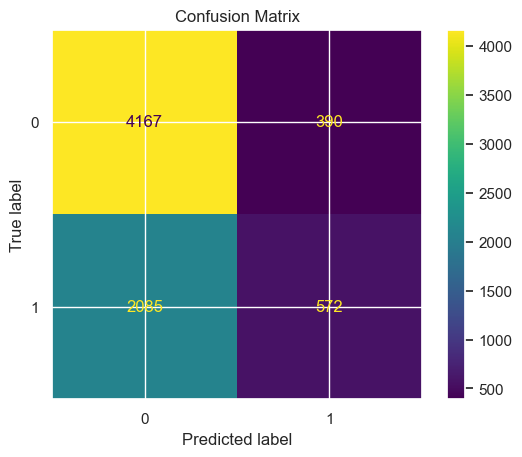

Accuracy: 0.6569171056279457
Balanced Accuracy: 0.5648488856370307
ROC AUC Score: 0.6701466532440795
Ratio of False Positives to False Negatives: 0.18705035971223022


In [ ]:
#TODO show a confusion matrix, compute accuracy, balanced accuracy, and roc_auc
#TODO compute ratio of false positives to false negatives
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import  balanced_accuracy_score, roc_auc_score

conf_matrix = confusion_matrix(Y_new, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)

ConfusionMatrixDisplay.from_predictions(Y_new, Y_pred)
plt.title("Confusion Matrix")
plt.show()


# Calculating accuracy
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
print(f"Accuracy: {accuracy}")

# Calculating balanced accuracy
balanced_acc = balanced_accuracy_score(Y_new, Y_pred)
print(f"Balanced Accuracy: {balanced_acc}")

# ROC AUC Score
# Note: You need probabilities, not just predictions, for ROC AUC
Y_proba_b = logit_model_a.predict_proba(X_b)[:, 1]
Y_proba_a = logit_model_b.predict_proba(X_a)[:, 1]
roc_auc = roc_auc_score(df_predictions['Y'], np.concatenate([Y_proba_a, Y_proba_b]))
print(f"ROC AUC Score: {roc_auc}")

# Ratio of False Positives to False Negatives
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
ratio_fp_fn = FP / FN if FN != 0 else float('inf')  # Check for division by zero
print(f"Ratio of False Positives to False Negatives: {ratio_fp_fn}")

### Compare treatment of whites and non-whites for recidivism prediction
##### Refer to week 11 for these concepts

#### Base Rates

In [ ]:
##TODO Compare base rates for recidivism outcomes of whites and non-whites

# Calculate the base rate for non-whites (NW_New == 1)
non_white_recidivism = Y_pred[NW_New == 1].sum()
total_non_whites = (NW_New == 1).sum()
non_white_base_rate = non_white_recidivism / total_non_whites if total_non_whites > 0 else 0

# Calculate the base rate for whites (NW_New == 0)
white_recidivism = Y_pred[NW_New == 0].sum()
total_whites = (NW_New == 0).sum()
white_base_rate = white_recidivism / total_whites if total_whites > 0 else 0

# Print the base rates
print("Base Rate for Whites:", white_base_rate)
print("Base Rate for Non-Whites:", non_white_base_rate)

Base Rate for Whites: 0.07742461287693561
Base Rate for Non-Whites: 0.16218487394957984


#### Performance

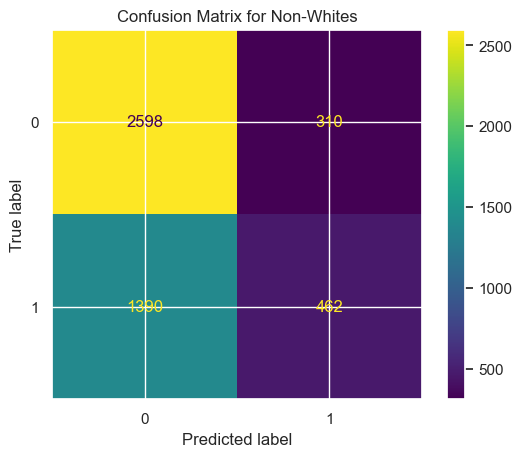

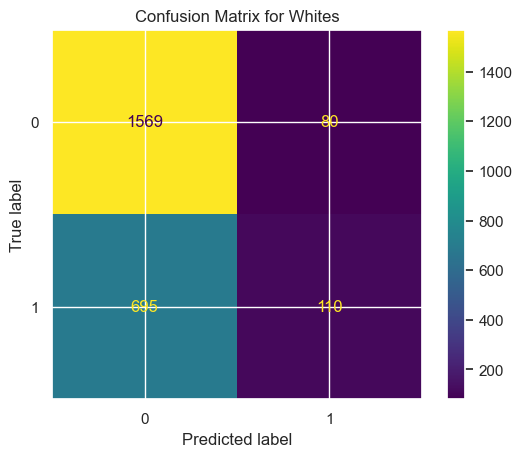


Classification Report for Non-Whites:
               precision    recall  f1-score   support

           0       0.65      0.89      0.75      2908
           1       0.60      0.25      0.35      1852

    accuracy                           0.64      4760
   macro avg       0.62      0.57      0.55      4760
weighted avg       0.63      0.64      0.60      4760


Classification Report for Whites:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80      1649
           1       0.58      0.14      0.22       805

    accuracy                           0.68      2454
   macro avg       0.64      0.54      0.51      2454
weighted avg       0.66      0.68      0.61      2454

Average Y_hat for Non-Whites: 	 0.16218487394957984
Average Y_hat for Whites: 	 0.07742461287693561 

Ratio of False Positives to False Negatives for Non-Whites: 0.22302158273381295
Ratio of False Positives to False Negatives for Whites: 0.11510791366906475


In [ ]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, separately for whites and non-whites.

# Combine Y and Y_pred into a single DataFrame for easier filtering
df_combined = df_predictions.copy()
df_combined['NW_New'] = NW_New

# Filter the data for non-whites
non_whites = df_combined[df_combined['NW_New'] == 1]
Y_non_whites = non_whites['Y']
Y_pred_non_whites = non_whites['Y_pred']

# Filter the data for whites
whites = df_combined[df_combined['NW_New'] == 0]
Y_whites = whites['Y']
Y_pred_whites = whites['Y_pred']

# Confusion Matrix and Classification Report for Non-Whites
ConfusionMatrixDisplay.from_predictions(Y_non_whites, Y_pred_non_whites)

plt.title("Confusion Matrix for Non-Whites")
plt.show()
conf_matrix_non_whites = confusion_matrix(Y_non_whites, Y_pred_non_whites)



# Confusion Matrix and Classification Report for Whites
conf_matrix_whites = confusion_matrix(Y_whites, Y_pred_whites)

ConfusionMatrixDisplay.from_predictions(Y_whites, Y_pred_whites)
plt.title("Confusion Matrix for Whites")
plt.show()

print("\nClassification Report for Non-Whites:\n", classification_report(Y_non_whites, Y_pred_non_whites))
print("\nClassification Report for Whites:\n", classification_report(Y_whites, Y_pred_whites))

# Ratio of False Positives to False Negatives for Non-Whites
FP_non_whites = conf_matrix_non_whites[0][1]
FN_non_whites = conf_matrix_non_whites[1][0]
ratio_fp_fn_non_whites = FP_non_whites / FN_non_whites if FN_non_whites != 0 else np.inf

# Ratio of False Positives to False Negatives for Whites
FP_whites = conf_matrix_whites[0][1]
FN_whites = conf_matrix_whites[1][0]
ratio_fp_fn_whites = FP_whites / FN_whites if FN_whites != 0 else np.inf

#Pr Y^hat = 1
Y_hat_whites = (conf_matrix_whites[0][1]+conf_matrix_whites[1][1])/(conf_matrix_whites[0][1]+conf_matrix_whites[1][1]+conf_matrix_whites[1][0]+conf_matrix_whites[0][0])
Y_hat_non_whites = (conf_matrix_non_whites[0][1]+conf_matrix_non_whites[1][1])/(conf_matrix_non_whites[0][1]+conf_matrix_non_whites[1][1]+conf_matrix_non_whites[1][0]+conf_matrix_non_whites[0][0])


#Print average Y^hat
print("Average Y_hat for Non-Whites: \t",Y_hat_non_whites )
print("Average Y_hat for Whites: \t", Y_hat_whites,"\n")


# Print the ratios
print("Ratio of False Positives to False Negatives for Non-Whites:", ratio_fp_fn_non_whites)
print("Ratio of False Positives to False Negatives for Whites:", ratio_fp_fn_whites)

**What concepts of "fairness" (from class) are (approximately) satisfied by this classifier? Explain.**

## Assessing Judges' Decisions: Predict Judge Decision from Features

In the following you will predict judges' decisions from defendants' features using a nested training/test split as before. In a second model, include Y-hat from previous section as a predictor.

In [ ]:
#TODO train a logit model to predict judge decision (D) from predictors (X). 


X_a2, X_b2, Y_a2, Y_b2, D_a2, D_b2 ,NW_a2, NW_b2 = train_test_split(X, Y, D, NW, test_size = 0.5)

judge_model_a = LogisticRegression()
judge_model_a.fit(X_a2, D_a2)

D_pred_b = judge_model_a.predict(X_b2)    

judge_model_b = LogisticRegression()
judge_model_b.fit(X_b2, D_b2)

# Make Predictions on Part A
D_pred_a = judge_model_b.predict(X_a2)

# Create DataFrame for the first split predictions
D_pred_a = pd.DataFrame({
    'D': D_a2,
    'D_pred': D_pred_a
})

# Create DataFrame for the second split predictions
D_pred_b = pd.DataFrame({
    'D': D_b2,
    'D_pred': D_pred_b
})

D_predictions = pd.concat([D_pred_a, D_pred_b], axis=0)

D_new = D_predictions['D']
D_pred = D_predictions['D_pred']


In [ ]:
#TODO train a logit model to predict judge decision (D) from predictors (X) and predicted recidivism risk (Yhat)
#TODO form clean test-set predictions for the decisions in the full dataset


X_enhanced = X.copy()
X_enhanced['Y_hat'] = Y_pred


### Compare treatment of whites and non-whites for recidivism prediction

In [ ]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, 
##TODO separately for whites and non-whites, and with/without including Y-hat as a predictor.


### Enforcing Statistical Parity

In this part you will find the the group-specific thresholds for both models of judges' decision (with/without Yhat) that obtain statistical parity.

You can use a custom classifier `threshold` for the decision with this type of code snippet: `decisions = (logit.predict_proba(X) >= threshold).astype(int)`.

#### Model without Yhat

In [ ]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites


#### Model with Yhat

In [ ]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites


# Bonus 1: More Fairness Constraints

Find the threshold for both models (with/without Yhat) that obtains error rate balance (equality of recalls for each class.

In [ ]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains predictive parity (equality of precisions for each class).

In [ ]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains treatment equality (ratio of false positives to false negatives).

In [ ]:
##TODO

# Bonus 2: Pre-Processing for Fairness

Regress all predictors in `X` on the protected attribute `A` and produce residuals `Xtilde`. Re-do the prediction task above (predicting judges' decision) and discuss how it changes the fairness metrics.

In [ ]:
##TODO